In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#  1. Initial data cleaning procedures

## 1.1 Normalizing strings on initial data load

In [3]:
def load_dataset(filename):
    df = pd.read_csv(filename)
    df.columns = df.columns.str.lower().str.replace(' ', '_', regex=False)
    string_columns = list(df.dtypes[df.dtypes == 'object'].index)
    numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)
    
    for col in string_columns:
        df[col] = df[col].str.lower().str.replace(' ', '_', regex=False)
    
    df.asymmetrique_activity_index = df.asymmetrique_activity_index.str.split('.', n = 1, expand = True)[1]
    df.asymmetrique_profile_index = df.asymmetrique_profile_index.str.split('.', n = 1, expand = True)[1]
    
    return df, string_columns, numerical_columns

In [4]:
df, string_columns, numerical_columns = load_dataset('leads.csv')

In [5]:
df.head().T

,0,1,2,3,4
prospect_id,7927b2df-8bba-4d29-b9a2-b6e0beafe620,2a272436-5132-4136-86fa-dcc88c88f482,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,3256f628-e534-4826-9d63-4a8b88782852
lead_number,660737,660728,660727,660719,660681
lead_origin,api,api,landing_page_submission,landing_page_submission,landing_page_submission
lead_source,olark_chat,organic_search,direct_traffic,direct_traffic,google
do_not_email,no,no,no,no,no
do_not_call,no,no,no,no,no
converted,0,0,1,0,1
totalvisits,0.0,5.0,2.0,1.0,2.0
total_time_spent_on_website,0,674,1532,305,1428
page_views_per_visit,0.0,2.5,2.0,1.0,1.0


In [6]:
df.shape

(9240, 37)

In [7]:
df.dtypes

prospect_id                                       object
lead_number                                        int64
lead_origin                                       object
lead_source                                       object
do_not_email                                      object
do_not_call                                       object
converted                                          int64
totalvisits                                      float64
total_time_spent_on_website                        int64
page_views_per_visit                             float64
last_activity                                     object
country                                           object
specialization                                    object
how_did_you_hear_about_x_education                object
what_is_your_current_occupation                   object
what_matters_most_to_you_in_choosing_a_course     object
search                                            object
magazine                       

## 1.2 Converting int -> float records on 'total time spent' column

In [8]:
df.total_time_spent_on_website = df.total_time_spent_on_website.astype(float)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   prospect_id                                    9240 non-null   object 
 1   lead_number                                    9240 non-null   int64  
 2   lead_origin                                    9240 non-null   object 
 3   lead_source                                    9204 non-null   object 
 4   do_not_email                                   9240 non-null   object 
 5   do_not_call                                    9240 non-null   object 
 6   converted                                      9240 non-null   int64  
 7   totalvisits                                    9103 non-null   float64
 8   total_time_spent_on_website                    9240 non-null   float64
 9   page_views_per_visit                           9103 

In [10]:
df.describe()

,lead_number,converted,totalvisits,total_time_spent_on_website,page_views_per_visit,asymmetrique_activity_score,asymmetrique_profile_score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


## 1.3 Dealing with missing values in the DataFrame

In [11]:
df.isnull().sum()

prospect_id                                         0
lead_number                                         0
lead_origin                                         0
lead_source                                        36
do_not_email                                        0
do_not_call                                         0
converted                                           0
totalvisits                                       137
total_time_spent_on_website                         0
page_views_per_visit                              137
last_activity                                     103
country                                          2461
specialization                                   1438
how_did_you_hear_about_x_education               2207
what_is_your_current_occupation                  2690
what_matters_most_to_you_in_choosing_a_course    2709
search                                              0
magazine                                            0
newspaper_article           

## 1.4 Filling null values in DataFrame

In [12]:
def filling_null_values(df, fill_strategy, column_type):
    imputer = SimpleImputer(strategy=fill_strategy)

    for col in column_type:
        df[col] = imputer.fit_transform(df[col].values.reshape(-1,1))[:,0]

In [13]:
filling_null_values(df, 'most_frequent', string_columns)

In [14]:
filling_null_values(df, 'mean', numerical_columns)

In [15]:
df.isnull().sum()

prospect_id                                      0
lead_number                                      0
lead_origin                                      0
lead_source                                      0
do_not_email                                     0
do_not_call                                      0
converted                                        0
totalvisits                                      0
total_time_spent_on_website                      0
page_views_per_visit                             0
last_activity                                    0
country                                          0
specialization                                   0
how_did_you_hear_about_x_education               0
what_is_your_current_occupation                  0
what_matters_most_to_you_in_choosing_a_course    0
search                                           0
magazine                                         0
newspaper_article                                0
x_education_forums             

# 2. Exploratory Data Analysis

## 2.1 Distribution of values in the target variable

In [16]:
df.converted.value_counts()

0.0    5679
1.0    3561
Name: converted, dtype: int64

<AxesSubplot:xlabel='converted', ylabel='count'>

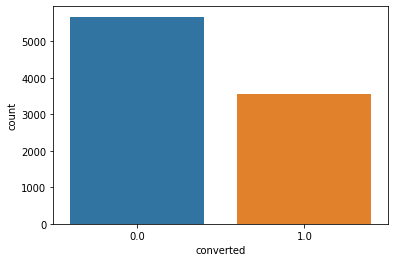

In [17]:
sns.countplot(x="converted", data=df)

## 2.2 Global lead convertion rate

### 2.2.1 We can see that the data set is unbalanced, because the distribution of leads that converted and that who didn't are different. Non-converted lead class dominates converted lead class and it's about 1.6 times higher

In [18]:
global_mean = df.converted.mean()
round(global_mean,2)

0.39

In [19]:
imbalance_ratio = 1 - round(global_mean,2) 
imbalance_percentage = imbalance_ratio / round(global_mean,2)

imbalance_ratio, imbalance_percentage

(0.61, 1.564102564102564)

In [20]:
df.nunique()

prospect_id                                      9240
lead_number                                      9240
lead_origin                                         5
lead_source                                        20
do_not_email                                        2
do_not_call                                         2
converted                                           2
totalvisits                                        42
total_time_spent_on_website                      1731
page_views_per_visit                              115
last_activity                                      17
country                                            38
specialization                                     19
how_did_you_hear_about_x_education                 10
what_is_your_current_occupation                     6
what_matters_most_to_you_in_choosing_a_course       3
search                                              2
magazine                                            1
newspaper_article           

In [21]:
df.city.value_counts()

mumbai                         4642
select                         2249
thane_&_outskirts               752
other_cities                    686
other_cities_of_maharashtra     457
other_metro_cities              380
tier_ii_cities                   74
Name: city, dtype: int64

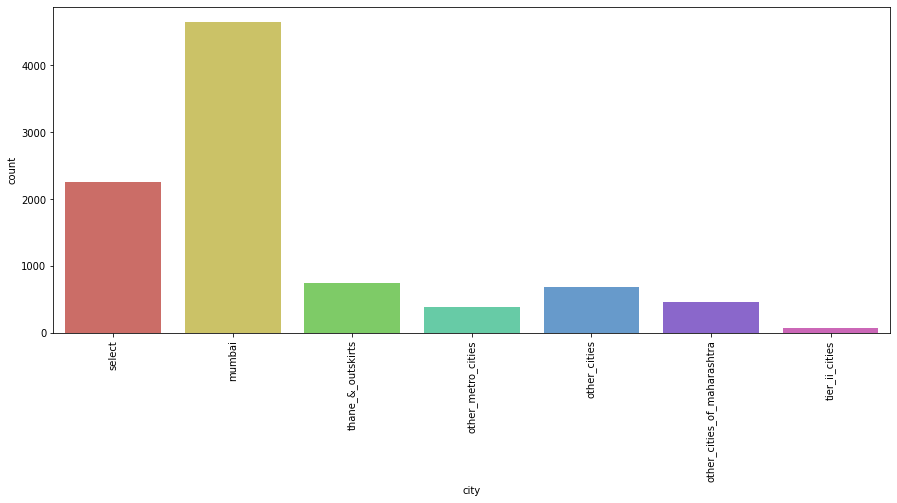

In [22]:
plt.figure(figsize=(15,6))

sns.countplot('city', data = df, palette='hls') 
plt.xticks(rotation = 90)

plt.show()

In [23]:
df.country.value_counts()

india                   8953
united_states             69
united_arab_emirates      53
singapore                 24
saudi_arabia              21
united_kingdom            15
australia                 13
qatar                     10
hong_kong                  7
bahrain                    7
oman                       6
france                     6
unknown                    5
south_africa               4
nigeria                    4
germany                    4
kuwait                     4
canada                     4
sweden                     3
china                      2
asia/pacific_region        2
uganda                     2
bangladesh                 2
italy                      2
belgium                    2
netherlands                2
ghana                      2
philippines                2
russia                     1
switzerland                1
vietnam                    1
denmark                    1
tanzania                   1
liberia                    1
malaysia      

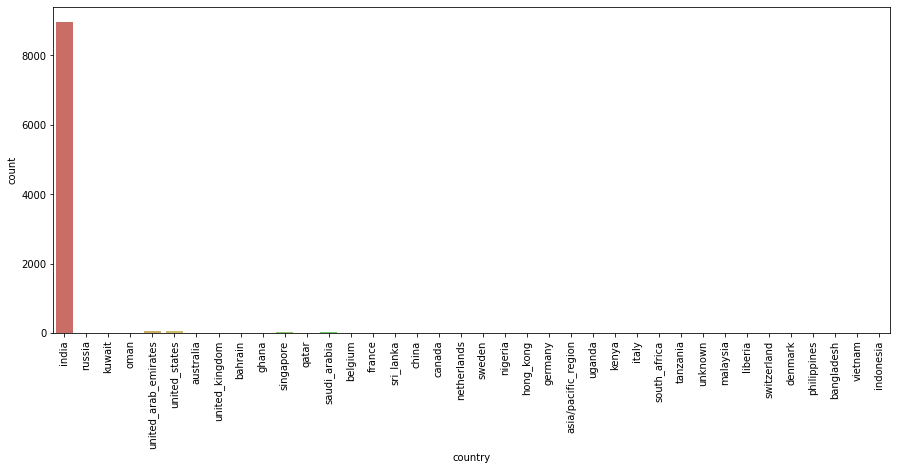

In [24]:
plt.figure(figsize=(15,6))

sns.countplot('country', data = df, palette='hls') 
plt.xticks(rotation = 90)

plt.show()

In [25]:
df.specialization.value_counts()

select                               3380
finance_management                    976
human_resource_management             848
marketing_management                  838
operations_management                 503
business_administration               403
it_projects_management                366
supply_chain_management               349
banking,_investment_and_insurance     338
travel_and_tourism                    203
media_and_advertising                 203
international_business                178
healthcare_management                 159
hospitality_management                114
e-commerce                            112
retail_management                     100
rural_and_agribusiness                 73
e-business                             57
services_excellence                    40
Name: specialization, dtype: int64

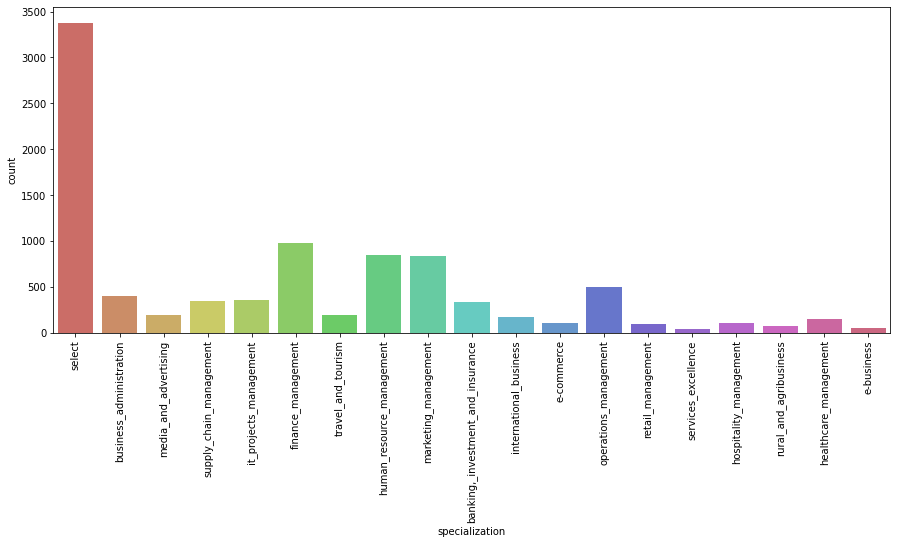

In [26]:
plt.figure(figsize=(15,6))

sns.countplot('specialization', data = df, palette='hls') 
plt.xticks(rotation = 90)

plt.show()

## 2.3 Columns with just one unique value are useless for building the future model, so there is a need to drop them

In [27]:
def drop_one_distinct_value_columns(df):
    for col in df.columns:
        if len(df[col].unique()) == 1:
            df.drop(col,inplace=True,axis=1)

In [28]:
drop_one_distinct_value_columns(df)

In [29]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,9230,9231,9232,9233,9234,9235,9236,9237,9238,9239
prospect_id,7927b2df-8bba-4d29-b9a2-b6e0beafe620,2a272436-5132-4136-86fa-dcc88c88f482,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,3256f628-e534-4826-9d63-4a8b88782852,2058ef08-2858-443e-a01f-a9237db2f5ce,9fae7df4-169d-489b-afe4-0f3d752542ed,20ef72a2-fb3b-45e0-924e-551c5fa59095,cfa0128c-a0da-4656-9d47-0aa4e67bf690,af465dfc-7204-4130-9e05-33231863c4b5,...,d11c15b7-8056-45a6-8954-771c0d0495fe,4aeae36b-2b57-494f-bdab-dd58844286b4,2d0109e9-dfb2-4664-83de-c2ea75ec7516,3f715465-2546-47cd-afa8-8b8dc63b8b43,c0b25922-511f-4c56-852e-ced210a45447,19d6451e-fcd6-407c-b83b-48e1af805ea9,82a7005b-7196-4d56-95ce-a79f937a158d,aac550fe-a586-452d-8d3c-f1b62c94e02c,5330a7d1-2f2b-4df4-85d6-64ca2f6b95b9,571b5c8e-a5b2-4d57-8574-f2ffb06fdeff
lead_number,660737.0,660728.0,660727.0,660719.0,660681.0,660680.0,660673.0,660664.0,660624.0,660616.0,...,579701.0,579697.0,579642.0,579622.0,579615.0,579564.0,579546.0,579545.0,579538.0,579533.0
lead_origin,api,api,landing_page_submission,landing_page_submission,landing_page_submission,api,landing_page_submission,api,landing_page_submission,api,...,landing_page_submission,landing_page_submission,landing_page_submission,api,landing_page_submission,landing_page_submission,landing_page_submission,landing_page_submission,landing_page_submission,landing_page_submission
lead_source,olark_chat,organic_search,direct_traffic,direct_traffic,google,olark_chat,google,olark_chat,direct_traffic,google,...,google,google,direct_traffic,direct_traffic,direct_traffic,direct_traffic,direct_traffic,direct_traffic,google,direct_traffic
do_not_email,no,no,no,no,no,no,no,no,no,no,...,no,no,no,no,no,yes,no,yes,no,no
do_not_call,no,no,no,no,no,no,no,no,no,no,...,no,no,no,no,no,no,no,no,no,no
converted,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
totalvisits,0.0,5.0,2.0,1.0,2.0,0.0,2.0,0.0,2.0,4.0,...,2.0,8.0,2.0,13.0,5.0,8.0,2.0,2.0,3.0,6.0
total_time_spent_on_website,0.0,674.0,1532.0,305.0,1428.0,0.0,1640.0,0.0,71.0,58.0,...,870.0,1016.0,1770.0,1409.0,210.0,1845.0,238.0,199.0,499.0,1279.0
page_views_per_visit,0.0,2.5,2.0,1.0,1.0,0.0,2.0,0.0,2.0,4.0,...,2.0,4.0,2.0,2.6,2.5,2.67,2.0,2.0,3.0,3.0


In [30]:
df.drop(['prospect_id', 'lead_number'], axis=1, inplace=True)

In [31]:
categorical = ['lead_origin', 'lead_source', 'do_not_email', 'do_not_call',
       'last_activity', 'country', 'specialization',
       'how_did_you_hear_about_x_education', 'what_is_your_current_occupation',
       'what_matters_most_to_you_in_choosing_a_course', 'search',
       'newspaper_article', 'newspaper', 'digital_advertisement',
       'through_recommendations', 'tags', 'lead_quality', 'lead_profile',
       'city', 'asymmetrique_activity_index', 'asymmetrique_profile_index',
       'a_free_copy_of_mastering_the_interview', 'last_notable_activity']

numerical = ['totalvisits', 'totalvisits', 'total_time_spent_on_website', 'page_views_per_visit', 
             'asymmetrique_activity_score', 'asymmetrique_profile_score']

## 2.4 Feature importance

### 2.4.1 Overview of lead conversion rate (which is here just mean value, because target variable is categorical) and lead conversion risk ratio (chance to become an actual client) for each group of categorical variables - it's really helpful for better understanding of data

In [32]:
for col in categorical:
    df_group = df.groupby(by=col).converted.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['convert_risk'] = df_group['mean'] / global_mean
    display(df_group)

,mean,diff,convert_risk
lead_origin,,,
api,0.311453,-0.073937,0.808150
landing_page_submission,0.361850,-0.023539,0.938920
lead_add_form,0.924791,0.539401,2.399626
lead_import,0.236364,-0.149026,0.613311
quick_add_form,1.000000,0.614610,2.594777


,mean,diff,convert_risk
lead_source,,,
bing,0.166667,-0.218723,0.432463
blog,0.000000,-0.385390,0.000000
click2call,0.750000,0.364610,1.946083
direct_traffic,0.321667,-0.063722,0.834655
facebook,0.236364,-0.149026,0.613311
google,0.404263,0.018873,1.048971
live_chat,1.000000,0.614610,2.594777
nc_edm,1.000000,0.614610,2.594777
olark_chat,0.255271,-0.130119,0.662370


,mean,diff,convert_risk
do_not_email,,,
no,0.404773,0.019383,1.050296
yes,0.160763,-0.224627,0.417144


,mean,diff,convert_risk
do_not_call,,,
no,0.385257,-0.000133,0.999655
yes,1.000000,0.614610,2.594777


,mean,diff,convert_risk
last_activity,,,
approached_upfront,1.000000,0.614610,2.594777
converted_to_lead,0.126168,-0.259221,0.327378
email_bounced,0.079755,-0.305635,0.206945
email_link_clicked,0.273408,-0.111981,0.709433
email_marked_spam,1.000000,0.614610,2.594777
email_opened,0.376836,-0.008553,0.977806
email_received,1.000000,0.614610,2.594777
form_submitted_on_website,0.241379,-0.144010,0.626325
had_a_phone_conversation,0.733333,0.347944,1.902836


,mean,diff,convert_risk
country,,,
asia/pacific_region,0.500000,0.114610,1.297388
australia,0.230769,-0.154620,0.598795
bahrain,0.571429,0.186039,1.482730
bangladesh,0.500000,0.114610,1.297388
belgium,0.000000,-0.385390,0.000000
canada,0.000000,-0.385390,0.000000
china,0.000000,-0.385390,0.000000
denmark,1.000000,0.614610,2.594777
france,0.500000,0.114610,1.297388


,mean,diff,convert_risk
specialization,,,
"banking,_investment_and_insurance",0.494083,0.108693,1.282035
business_administration,0.444169,0.058779,1.152519
e-business,0.368421,-0.016969,0.955970
e-commerce,0.357143,-0.028247,0.926706
finance_management,0.446721,0.061332,1.159142
healthcare_management,0.496855,0.111466,1.289229
hospitality_management,0.421053,0.035663,1.092538
human_resource_management,0.457547,0.072158,1.187233
international_business,0.359551,-0.025839,0.932953


,mean,diff,convert_risk
how_did_you_hear_about_x_education,,,
advertisements,0.457143,0.071753,1.186184
email,0.500000,0.114610,1.297388
multiple_sources,0.368421,-0.016969,0.955970
online_search,0.424505,0.039115,1.101496
other,0.403226,0.017836,1.046281
select,0.374345,-0.011045,0.971341
sms,0.217391,-0.167998,0.564082
social_media,0.417910,0.032521,1.084384
student_of_someschool,0.461290,0.075901,1.196945


,mean,diff,convert_risk
what_is_your_current_occupation,,,
businessman,0.625000,0.239610,1.621735
housewife,1.000000,0.614610,2.594777
other,0.625000,0.239610,1.621735
student,0.371429,-0.013961,0.963774
unemployed,0.339083,-0.046306,0.879845
working_professional,0.916431,0.531041,2.377933


,mean,diff,convert_risk
what_matters_most_to_you_in_choosing_a_course,,,
better_career_prospects,0.385407,0.000017,1.000044
flexibility_&_convenience,0.500000,0.114610,1.297388
other,0.000000,-0.385390,0.000000


,mean,diff,convert_risk
search,,,
no,0.385432,0.000043,1.000111
yes,0.357143,-0.028247,0.926706


,mean,diff,convert_risk
newspaper_article,,,
no,0.385365,-0.000025,0.999936
yes,0.500000,0.114610,1.297388


,mean,diff,convert_risk
newspaper,,,
no,0.385431,0.000042,1.000108
yes,0.000000,-0.385390,0.000000


,mean,diff,convert_risk
digital_advertisement,,,
no,0.385448,0.000059,1.000152
yes,0.250000,-0.135390,0.648694


,mean,diff,convert_risk
through_recommendations,,,
no,0.385140,-0.000249,0.999353
yes,0.714286,0.328896,1.853412


,mean,diff,convert_risk
tags,,,
already_a_student,0.006452,-0.378938,0.016740
busy,0.564516,0.179127,1.464793
closed_by_horizzon,0.994413,0.609024,2.580281
diploma_holder_(not_eligible),0.015873,-0.369517,0.041187
graduation_in_progress,0.063063,-0.322327,0.163635
in_confusion_whether_part_time_or_dlp,0.200000,-0.185390,0.518955
in_touch_with_eins,0.250000,-0.135390,0.648694
interested__in_full_time_mba,0.025641,-0.359749,0.066533
interested_in_next_batch,1.000000,0.614610,2.594777


,mean,diff,convert_risk
lead_quality,,,
high_in_relevance,0.946625,0.561235,2.456280
low_in_relevance,0.818182,0.432792,2.122999
might_be,0.348190,-0.037199,0.903476
not_sure,0.243590,-0.141800,0.632061
worst,0.019967,-0.365423,0.051809


,mean,diff,convert_risk
lead_profile,,,
dual_specialization_student,1.000000,0.614610,2.594777
lateral_student,0.958333,0.572944,2.486661
other_leads,0.369610,-0.015780,0.959055
potential_lead,0.785493,0.400103,2.038179
select,0.300802,-0.084587,0.780515
student_of_someschool,0.037344,-0.348045,0.096900


,mean,diff,convert_risk
city,,,
mumbai,0.315166,-0.070224,0.817785
other_cities,0.402332,0.016943,1.043963
other_cities_of_maharashtra,0.439825,0.054435,1.141248
other_metro_cities,0.407895,0.022505,1.058396
select,0.490440,0.105051,1.272583
thane_&_outskirts,0.449468,0.064078,1.166269
tier_ii_cities,0.337838,-0.047552,0.876614


,mean,diff,convert_risk
asymmetrique_activity_index,,,
high,0.298417,-0.086973,0.774324
low,0.091160,-0.294229,0.236540
medium,0.407472,0.022082,1.057298


,mean,diff,convert_risk
asymmetrique_profile_index,,,
high,0.474353,0.088964,1.230841
low,0.483871,0.098481,1.255537
medium,0.356980,-0.028410,0.926283


,mean,diff,convert_risk
a_free_copy_of_mastering_the_interview,,,
no,0.398457,0.013068,1.033907
yes,0.356648,-0.028741,0.925422


,mean,diff,convert_risk
last_notable_activity,,,
approached_upfront,1.000000,0.614610,2.594777
email_bounced,0.150000,-0.235390,0.389217
email_link_clicked,0.260116,-0.125274,0.674942
email_marked_spam,1.000000,0.614610,2.594777
email_opened,0.369296,-0.016094,0.958241
email_received,1.000000,0.614610,2.594777
form_submitted_on_website,0.000000,-0.385390,0.000000
had_a_phone_conversation,0.928571,0.543182,2.409436
modified,0.229821,-0.155569,0.596334


### 2.4.2 Mutual information - usage for it is to better measure the dependency between a categorical variable, and the target variable

In [33]:
def calc_mutal_info_score(series):
    return mutual_info_score(series, df.converted)

In [34]:
df_mutual_info = df[categorical].apply(calc_mutal_info_score)
df_mutual_info = df_mutual_info.sort_values(ascending=False).to_frame(name="mutual_info")
df_mutual_info

,mutual_info
tags,0.206630
lead_quality,0.107821
last_activity,0.084493
lead_profile,0.082869
last_notable_activity,0.073860
lead_source,0.061560
lead_origin,0.056251
what_is_your_current_occupation,0.053389
specialization,0.014624
city,0.012024


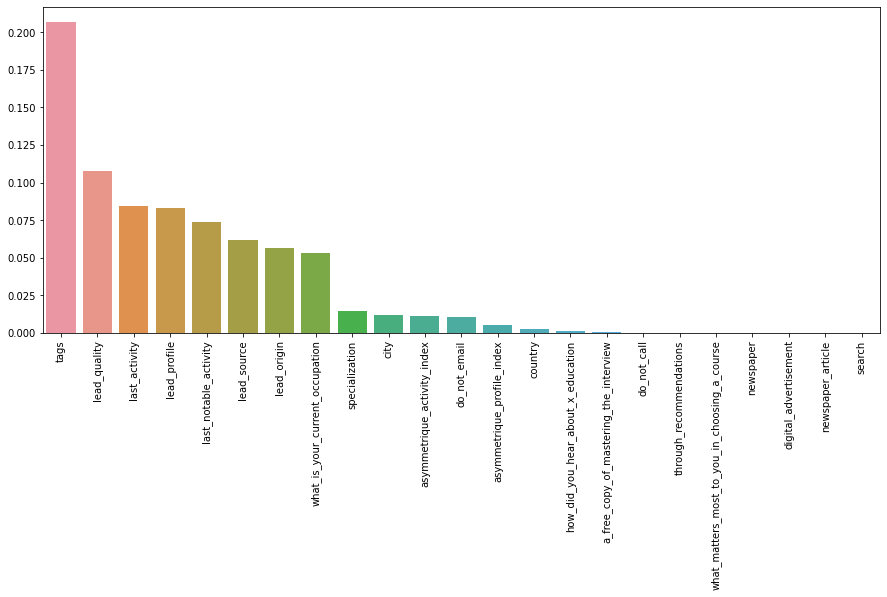

In [35]:
plt.figure(figsize=(15,6))

sns.barplot(data=df_mutual_info.T)
plt.xticks(rotation = 90)

plt.show()

In [36]:
important_features = df_mutual_info.loc[df_mutual_info.mutual_info > 0.02]
important_features

,mutual_info
tags,0.206630
lead_quality,0.107821
last_activity,0.084493
lead_profile,0.082869
last_notable_activity,0.073860
lead_source,0.061560
lead_origin,0.056251
what_is_your_current_occupation,0.053389


In [37]:
base_feautres = categorical + numerical
important_categorical_features = list(important_features.T.columns)

### 2.4.3 Correlation coefficient -  usage for it is to better measure the dependency between a binary target variable and a numerical feature

In [38]:
df[numerical].corrwith(df.converted).sort_values(ascending=False)

total_time_spent_on_website    0.362483
asymmetrique_profile_score     0.160700
asymmetrique_activity_score    0.123491
totalvisits                    0.030091
totalvisits                    0.030091
page_views_per_visit          -0.003294
dtype: float64

### Here, on the ’total_time_spent’ column, is shown positive correlation between the target variable, so when people are spending more time on the course website, then they are more likely going to convert into actual customers. Here it’s able to observe the opposite case with a negative correlation on the ‘page_views_per_visit’ column and that means if page views are higher, then people less likely going to convert.

<AxesSubplot:xlabel='converted', ylabel='total_time_spent_on_website'>

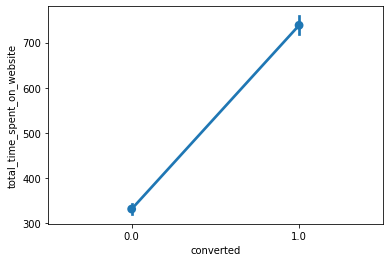

In [39]:
sns.pointplot(x="converted", y="total_time_spent_on_website", data=df)

<AxesSubplot:xlabel='converted', ylabel='page_views_per_visit'>

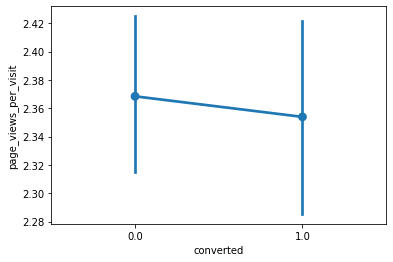

In [40]:
sns.pointplot(x="converted", y="page_views_per_visit", data=df)

# 3. Split data into train, validation and test datasets

In [41]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train, df_valid = train_test_split(df_train_full, test_size=0.25, random_state=1)

y_train = df_train.converted.values
y_valid = df_valid.converted.values

del df_train['converted']
del df_valid['converted']

## 3.1 One-hot encoding for categorical features during model training

In [42]:
def train_model(df, y, cat_features):
    dictionary = df[cat_features + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(dictionary)

    X = dv.transform(dictionary)
    
    model = LogisticRegression(solver='liblinear',random_state=1)
    model.fit(X, y)
    
    return dv, model

# 4. Logistic regression and making predictions

In [43]:
dv, model = train_model(df_train, y_train, categorical)

In [44]:
def make_prediction(df, dv, model, cat_features):
    dictionary = df[cat_features + numerical].to_dict(orient='records')
    
    X = dv.transform(dictionary)
    y_prediction = model.predict_proba(X)[:,1]
    
    return y_prediction

In [45]:
y_prediction = make_prediction(df_valid, dv, model, categorical)

## 4.1 Accuracy of the model

### The assumption of threshold is that every lead with score above > 0.5 is going to convert:

In [46]:
converted = y_prediction >= 0.5
accuracy_score(y_valid, converted)

0.926948051948052

### The best accuracy is for threshold = 0.4:

In [47]:
tresholds = np.linspace(0, 1, 11)

maximum = (0.0,0.0)
converted = []
acc = 0.0
for t in tresholds:
    converted = y_prediction >= t
    acc = accuracy_score(y_valid, converted)
    if acc > maximum[0]:
        maximum = (acc,t)
        
best_threshold = maximum[1]
best_acc = maximum[0]
print(best_acc, best_threshold)

0.9334415584415584 0.4


## 4.2 ROC curves and Area Under the ROC curve (AUC score)

In [48]:
def draw_roc_curve(y_valid, y_prediction):
    fpr, tpr, _ = roc_curve(y_valid,  y_prediction, drop_intermediate=False)
    auc_score = roc_auc_score(y_valid, y_prediction)
    
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    
    plt.show()
    return auc_score

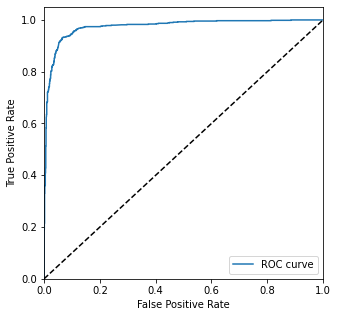

0.9741369090330512

In [49]:
biased_roc = draw_roc_curve(y_valid, y_prediction)
biased_roc

## ROC curve of the model could be biased, because of the 'lead_quality' and 'tags' columns. Information from these columns is hardly subjective and made by the company, so they might be the cause of bias. The decision about dropping these off from the categorical features list is made.

In [50]:
categorical_2 = ['lead_origin', 'lead_source', 'do_not_email', 'do_not_call',
       'last_activity', 'country', 'specialization',
       'how_did_you_hear_about_x_education', 'what_is_your_current_occupation',
       'what_matters_most_to_you_in_choosing_a_course', 'search',
       'newspaper_article', 'newspaper', 'digital_advertisement',
       'through_recommendations', 'lead_profile',
       'city', 'asymmetrique_activity_index', 'asymmetrique_profile_index',
       'a_free_copy_of_mastering_the_interview', 'last_notable_activity']

In [51]:
dv_2, model_2 = train_model(df_train, y_train, categorical_2)
y_prediction_2 = make_prediction(df_valid, dv_2, model_2, categorical_2)

In [52]:
converted_2 = y_prediction_2 >= 0.5
accuracy_score(y_valid, converted_2)

0.8382034632034632

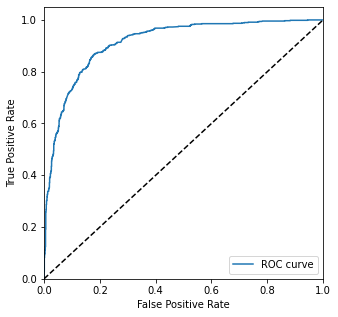

0.9137720179450542

In [53]:
fixed_roc = draw_roc_curve(y_valid, y_prediction_2)
fixed_roc

# 5. Model testing

In [54]:
df_check, string_columns_check, numerical_columns_check = load_dataset('leads.csv')

In [55]:
df_test.index

Int64Index([2140, 7707, 1522, 1873, 8100, 7332, 1094, 2397, 1103, 2257,
            ...
            1300, 4506, 8340, 8933, 2080, 1837, 7173,  634, 4406, 3465],
           dtype='int64', length=1848)

In [56]:
lead = df_test[categorical_2 + numerical].loc[2080].to_dict()
X_test = dv.transform(lead)
y_test_prediction = model.predict_proba(X_test)

y_test_prediction[:,1]

array([0.80900363])

In [57]:
y_test_actual = df_check.converted.loc[2080]
y_test_actual

1

In [58]:
(y_test_prediction[:,1] > best_threshold)  == y_test_actual

array([ True])